# Horse to Zebra Unpaired Image Translation with CycleGAN in FastEstimator

This notebook demonstrates how to perform an unpaired image to image translation using CycleGAN in FastEstimator.
The details of the method is found in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593).
We will specifically look at the problem of translating horse images to zebra images.

In [1]:
import tempfile

import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import normal_

import fastestimator as fe
from fastestimator.backend import reduce_mean

In [2]:
#Parameters
epochs = 200
batch_size = 1
max_train_steps_per_epoch = None
save_dir=tempfile.mkdtemp()
weight = 10.0
data_dir=None

In [3]:
# Parameters
epochs = 2
batch_size = 2
max_train_steps_per_epoch = 10


## Building Components

### Downloading the data
First, we will download the dataset of horses and zebras via our dataset API.
The images will be first downloaded from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/).
As this task requires an unpaired datasets of horse and zebra images, horse2zebra dataset is implemented using `BatchDataset` in FastEstimator. Hence, we need to specify the batch size while loading the dataset.

In [4]:
from fastestimator.dataset.data.horse2zebra import load_data
train_data, test_data = load_data(batch_size=batch_size, root_dir=data_dir)

  0% [                                                  ]      0.00 / 116.87 MB

  0% [                                                  ]      0.57 / 116.87 MB

  1% [                                                  ]      1.56 / 116.87 MB

  2% [.                                                 ]      2.87 / 116.87 MB

  3% [.                                                 ]      4.21 / 116.87 MB

  4% [..                                                ]      5.49 / 116.87 MB

  5% [..                                                ]      6.44 / 116.87 MB

  6% [...                                               ]      7.42 / 116.87 MB

  7% [...                                               ]      8.45 / 116.87 MB

  8% [....                                              ]      9.44 / 116.87 MB

  9% [....                                              ]     10.57 / 116.87 MB

  9% [....                                              ]     11.63 / 116.87 MB

 10% [.....                                             ]     12.48 / 116.87 MB

 11% [.....                                             ]     13.40 / 116.87 MB

 12% [......                                            ]     14.35 / 116.87 MB

 13% [......                                            ]     15.31 / 116.87 MB

 13% [......                                            ]     16.30 / 116.87 MB

 14% [.......                                           ]     17.35 / 116.87 MB

 15% [.......                                           ]     18.45 / 116.87 MB

 16% [........                                          ]     19.60 / 116.87 MB

 17% [........                                          ]     20.79 / 116.87 MB

 18% [.........                                         ]     22.00 / 116.87 MB

 19% [.........                                         ]     23.30 / 116.87 MB

 21% [..........                                        ]     24.63 / 116.87 MB

 22% [...........                                       ]     25.97 / 116.87 MB

 23% [...........                                       ]     27.34 / 116.87 MB

 24% [............                                      ]     28.74 / 116.87 MB

 25% [............                                      ]     30.23 / 116.87 MB

 26% [.............                                     ]     31.43 / 116.87 MB

 27% [.............                                     ]     32.21 / 116.87 MB

 28% [..............                                    ]     33.00 / 116.87 MB

 28% [..............                                    ]     33.51 / 116.87 MB

 29% [..............                                    ]     34.16 / 116.87 MB

 29% [..............                                    ]     34.82 / 116.87 MB

 30% [...............                                   ]     35.54 / 116.87 MB

 31% [...............                                   ]     36.31 / 116.87 MB

 31% [...............                                   ]     37.09 / 116.87 MB

 32% [................                                  ]     37.91 / 116.87 MB

 33% [................                                  ]     38.81 / 116.87 MB

 33% [................                                  ]     39.72 / 116.87 MB

 34% [.................                                 ]     40.70 / 116.87 MB

 35% [.................                                 ]     41.67 / 116.87 MB

 36% [..................                                ]     42.71 / 116.87 MB

 37% [..................                                ]     43.70 / 116.87 MB

 38% [...................                               ]     44.55 / 116.87 MB

 38% [...................                               ]     45.38 / 116.87 MB

 39% [...................                               ]     46.22 / 116.87 MB

 40% [....................                              ]     47.19 / 116.87 MB

 41% [....................                              ]     48.14 / 116.87 MB

 42% [.....................                             ]     49.17 / 116.87 MB

 42% [.....................                             ]     50.10 / 116.87 MB

 43% [.....................                             ]     50.64 / 116.87 MB

 43% [.....................                             ]     51.23 / 116.87 MB

 44% [......................                            ]     51.86 / 116.87 MB

 44% [......................                            ]     52.53 / 116.87 MB

 45% [......................                            ]     53.25 / 116.87 MB

 46% [.......................                           ]     54.00 / 116.87 MB

 46% [.......................                           ]     54.80 / 116.87 MB

 47% [.......................                           ]     55.66 / 116.87 MB

 48% [........................                          ]     56.56 / 116.87 MB

 49% [........................                          ]     57.49 / 116.87 MB

 50% [.........................                         ]     58.46 / 116.87 MB

 50% [.........................                         ]     59.41 / 116.87 MB

 51% [.........................                         ]     60.46 / 116.87 MB

 52% [..........................                        ]     61.55 / 116.87 MB

 53% [..........................                        ]     62.67 / 116.87 MB

 54% [...........................                       ]     63.83 / 116.87 MB

 55% [...........................                       ]     65.03 / 116.87 MB

 56% [............................                      ]     65.95 / 116.87 MB

 57% [............................                      ]     66.80 / 116.87 MB

 58% [.............................                     ]     67.81 / 116.87 MB

 58% [.............................                     ]     68.85 / 116.87 MB

 59% [.............................                     ]     69.85 / 116.87 MB

 60% [..............................                    ]     70.95 / 116.87 MB

 61% [..............................                    ]     72.07 / 116.87 MB

 62% [...............................                   ]     73.24 / 116.87 MB

 63% [...............................                   ]     74.43 / 116.87 MB

 64% [................................                  ]     75.68 / 116.87 MB

 65% [................................                  ]     76.94 / 116.87 MB

 67% [.................................                 ]     78.31 / 116.87 MB

 68% [..................................                ]     79.67 / 116.87 MB

 69% [..................................                ]     81.09 / 116.87 MB

 70% [...................................               ]     82.57 / 116.87 MB

 71% [...................................               ]     84.04 / 116.87 MB

 73% [....................................              ]     85.57 / 116.87 MB

 74% [.....................................             ]     87.15 / 116.87 MB

 75% [.....................................             ]     88.78 / 116.87 MB

 77% [......................................            ]     90.42 / 116.87 MB

 78% [.......................................           ]     91.90 / 116.87 MB

 79% [.......................................           ]     93.18 / 116.87 MB

 80% [........................................          ]     94.49 / 116.87 MB

 82% [.........................................         ]     95.86 / 116.87 MB

 83% [.........................................         ]     97.28 / 116.87 MB

 84% [..........................................        ]     98.75 / 116.87 MB

 85% [..........................................        ]    100.24 / 116.87 MB

 87% [...........................................       ]    101.79 / 116.87 MB

 88% [............................................      ]    103.35 / 116.87 MB

 89% [............................................      ]    104.96 / 116.87 MB

 91% [.............................................     ]    106.56 / 116.87 MB

 92% [..............................................    ]    108.22 / 116.87 MB

 94% [...............................................   ]    109.94 / 116.87 MB

 95% [...............................................   ]    111.26 / 116.87 MB

 96% [................................................  ]    112.54 / 116.87 MB

 97% [................................................  ]    113.93 / 116.87 MB

 98% [................................................. ]    115.38 / 116.87 MB

 99% [................................................. ]    116.82 / 116.87 MB

100% [..................................................]    116.87 / 116.87 MB

Extracting files ...


### Step 1: Create pipeline

Let's create the pipeline. As, batch_size must be `None` when BatchDataset is being used, we will not provide the batch_size argument.

In [5]:
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, RandomCrop, Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage

pipeline = fe.Pipeline(
    train_data=train_data,
    ops=[
        ReadImage(inputs=["A", "B"], outputs=["A", "B"]),
        Normalize(inputs=["A", "B"], outputs=["real_A", "real_B"], mean=1.0, std=1.0, max_pixel_value=127.5),
        Resize(height=286, width=286, image_in="real_A", image_out="real_A", mode="train"),
        RandomCrop(height=256, width=256, image_in="real_A", image_out="real_A", mode="train"),
        Resize(height=286, width=286, image_in="real_B", image_out="real_B", mode="train"),
        RandomCrop(height=256, width=256, image_in="real_B", image_out="real_B", mode="train"),
        Sometimes(HorizontalFlip(image_in="real_A", image_out="real_A", mode="train")),
        Sometimes(HorizontalFlip(image_in="real_B", image_out="real_B", mode="train")),
        ChannelTranspose(inputs=["real_A", "real_B"], outputs=["real_A", "real_B"])
    ])

We can visualize sample images from the `pipeline` using `get_results` method.

In [6]:
def Minmax(img):
    img_max = np.max(img)
    img_min = np.min(img)
    img = (img - img_min)/max((img_max - img_min), 1e-7)
    img = (img*255).astype(np.uint8)
    return img

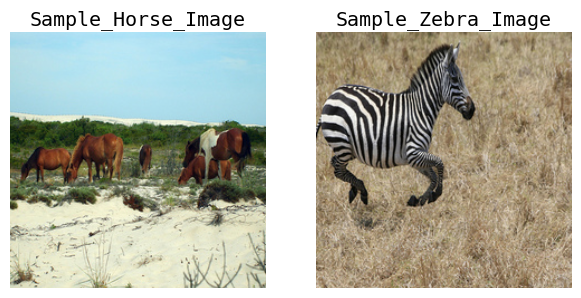

In [7]:
sample_batch = pipeline.get_results()
horse_img = sample_batch["real_A"][0]
horse_img = np.transpose(horse_img.numpy(), (1, 2, 0))
horse_img = np.expand_dims(Minmax(horse_img), 0)

zebra_img = sample_batch["real_B"][0]
zebra_img = np.transpose(zebra_img.numpy(), (1, 2, 0))
zebra_img = np.expand_dims(Minmax(zebra_img), 0)

img = fe.util.ImgData(Sample_Horse_Image=horse_img, Sample_Zebra_Image=zebra_img)
fig = img.paint_figure()

### Step 2: Create Network

In CycleGAN, there are 2 generators and 2 discriminators being trained.
* Generator `g_AtoB` learns to map horse images to zebra images
* Generator `g_BtoA` learns to map zebra images to horse images
* Discriminator `d_A` learns to differentiate between real hores images and fake horse images produced by `g_BtoA`
* Discriminator `d_B` learns to differentiate between image zebra and fake zebra images produced by `g_AtoB`

The architecture of generator is a modified resnet, and the architecture of discriminator is a PatchGAN.

In [8]:
class ResidualBlock(nn.Module):
    """Residual block architecture"""
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.layers = nn.Sequential(nn.ReflectionPad2d(1),
                                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size),
                                    nn.InstanceNorm2d(out_channels),
                                    nn.ReLU(inplace=True),
                                    nn.ReflectionPad2d(1),
                                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size),
                                    nn.InstanceNorm2d(out_channels))

        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                normal_(layer.weight.data, mean=0, std=0.02)

    def forward(self, x):
        x_out = self.layers(x)
        x_out = x_out + x
        return x_out


class Discriminator(nn.Module):
    """Discriminator network architecture"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                    nn.InstanceNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                    nn.InstanceNorm2d(256),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.ReflectionPad2d(1),
                                    nn.Conv2d(256, 512, kernel_size=4, stride=1),
                                    nn.InstanceNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.ReflectionPad2d(1),
                                    nn.Conv2d(512, 1, kernel_size=4, stride=1))

        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                normal_(layer.weight.data, mean=0, std=0.02)

    def forward(self, x):
        x = self.layers(x)
        return x


class Generator(nn.Module):
    """Generator network architecture"""
    def __init__(self, num_blocks=9):
        super().__init__()
        self.layers1 = nn.Sequential(nn.ReflectionPad2d(3),
                                     nn.Conv2d(3, 64, kernel_size=7, stride=1),
                                     nn.InstanceNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                     nn.InstanceNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                                     nn.InstanceNorm2d(256),
                                     nn.ReLU(inplace=True))
        self.resblocks = nn.Sequential(*[ResidualBlock(256, 256) for i in range(num_blocks)])
        self.layers2 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.InstanceNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.InstanceNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     nn.ReflectionPad2d(3),
                                     nn.Conv2d(64, 3, kernel_size=7, stride=1))

        for block in [self.layers1, self.layers2]:
            for layer in block:
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
                    normal_(layer.weight.data, mean=0, std=0.02)

    def forward(self, x):
        x = self.layers1(x)
        x = self.resblocks(x)
        x = self.layers2(x)
        x = torch.tanh(x)
        return x

In [9]:
g_AtoB = fe.build(model_fn=Generator,
                  model_name="g_AtoB",
                  optimizer_fn=lambda x: torch.optim.Adam(x, lr=2e-4, betas=(0.5, 0.999)))
g_BtoA = fe.build(model_fn=Generator,
                  model_name="g_BtoA",
                  optimizer_fn=lambda x: torch.optim.Adam(x, lr=2e-4, betas=(0.5, 0.999)))
d_A = fe.build(model_fn=Discriminator,
               model_name="d_A",
               optimizer_fn=lambda x: torch.optim.Adam(x, lr=2e-4, betas=(0.5, 0.999)))
d_B = fe.build(model_fn=Discriminator,
               model_name="d_B",
               optimizer_fn=lambda x: torch.optim.Adam(x, lr=2e-4, betas=(0.5, 0.999)))

### Defining Loss functions
For each network, we need to define associated losses.

Because horse images and zebra images are unpaired, the loss of generator is quite complex. 
The generator's loss is composed of three terms: 
    * adversarial
    * cycle-consistency
    * identity.
The cycle-consistency term and identity term are weighted by a parameter `LAMBDA`. In the paper the authors used 10 for `LAMBDA`.

Let's consider computing the loss for `g_AtoB` which translates horses to zebras.
1. Adversarial term that is computed as binary cross entropy between ones and `d_A`'s prediction on the translated images
2. Cycle consistency term is computed with mean absolute error between original *horse* images and the cycled horse images that are translated *forward* by `g_AtoB` and then *backward* by `g_BtoA`.
3. Identity term that is computed with the mean absolute error between original *zebra* and the output of `g_AtoB` on these images.

The discriminator's loss is the standard adversarial loss that is computed as binary cross entropy between:
* Ones and real images
* Zeros and fake images

In [10]:
from fastestimator.op.tensorop import TensorOp

class GLoss(TensorOp):
    """TensorOp to compute generator loss"""
    def __init__(self, inputs, weight, device, outputs=None, mode=None, average_loss=True):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.loss_fn = nn.MSELoss(reduction="none")
        self.LAMBDA = weight
        self.device = device
        self.average_loss = average_loss

    def _adversarial_loss(self, fake_img):
        return torch.mean(self.loss_fn(fake_img, torch.ones_like(fake_img, device=self.device)), dim=(2, 3))

    def _identity_loss(self, real_img, same_img):
        return 0.5 * self.LAMBDA * torch.mean(torch.abs(real_img - same_img), dim=(1, 2, 3))

    def _cycle_loss(self, real_img, cycled_img):
        return self.LAMBDA * torch.mean(torch.abs(real_img - cycled_img), dim=(1, 2, 3))

    def forward(self, data, state):
        real_img, fake_img, cycled_img, same_img = data
        total_loss = self._adversarial_loss(fake_img) + self._identity_loss(real_img, same_img) + self._cycle_loss(
            real_img, cycled_img)

        if self.average_loss:
            total_loss = reduce_mean(total_loss)

        return total_loss


class DLoss(TensorOp):
    """TensorOp to compute discriminator loss"""
    def __init__(self, inputs, device, outputs=None, mode=None, average_loss=True):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.loss_fn = nn.MSELoss(reduction="none")
        self.device = device
        self.average_loss = average_loss

    def forward(self, data, state):
        real_img, fake_img = data
        real_img_loss = torch.mean(self.loss_fn(real_img, torch.ones_like(real_img, device=self.device)), dim=(2, 3))
        fake_img_loss = torch.mean(self.loss_fn(fake_img, torch.zeros_like(real_img, device=self.device)), dim=(2, 3))
        total_loss = real_img_loss + fake_img_loss

        if self.average_loss:
            total_loss = reduce_mean(total_loss)

        return 0.5 * total_loss

We implement an image buffer as a `TensorOp` which stores the previous images produced by the generators to updated the discriminators as outlined in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593).

In [11]:
class Buffer(TensorOp):
    def __init__(self, image_in=None, image_out=None, mode=None, buffer_size=50):
        super().__init__(inputs=image_in, outputs=image_out, mode=mode)
        self.buffer_size = buffer_size
        self.num_imgs = 0
        self.image_buffer = []

    def forward(self, data, state):
        output = []
        for image in data:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.buffer_size:
                self.image_buffer.append(image)
                output.append(image)
                self.num_imgs += 1
            else:
                if np.random.uniform() > 0.5:
                    idx = np.random.randint(self.buffer_size)
                    temp = self.image_buffer[idx].clone()
                    self.image_buffer[idx] = image
                    output.append(temp)
                else:
                    output.append(image)

        output = torch.cat(output, 0)
        return output

Once associated losses are defined, we can now define the `Network` object.

In [12]:
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

device = "cuda" if torch.cuda.is_available() else "cpu"

network = fe.Network(ops=[
    ModelOp(inputs="real_A", model=g_AtoB, outputs="fake_B"),
    ModelOp(inputs="real_B", model=g_BtoA, outputs="fake_A"),
    Buffer(image_in="fake_A", image_out="buffer_fake_A"),
    Buffer(image_in="fake_B", image_out="buffer_fake_B"),
    ModelOp(inputs="real_A", model=d_A, outputs="d_real_A"),
    ModelOp(inputs="fake_A", model=d_A, outputs="d_fake_A"),
    ModelOp(inputs="buffer_fake_A", model=d_A, outputs="buffer_d_fake_A"),
    ModelOp(inputs="real_B", model=d_B, outputs="d_real_B"),
    ModelOp(inputs="fake_B", model=d_B, outputs="d_fake_B"),
    ModelOp(inputs="buffer_fake_B", model=d_B, outputs="buffer_d_fake_B"),
    ModelOp(inputs="real_A", model=g_BtoA, outputs="same_A"),
    ModelOp(inputs="fake_B", model=g_BtoA, outputs="cycled_A"),
    ModelOp(inputs="real_B", model=g_AtoB, outputs="same_B"),
    ModelOp(inputs="fake_A", model=g_AtoB, outputs="cycled_B"),
    GLoss(inputs=("real_A", "d_fake_B", "cycled_A", "same_A"), weight=weight, device=device, outputs="g_AtoB_loss"),
    GLoss(inputs=("real_B", "d_fake_A", "cycled_B", "same_B"), weight=weight, device=device, outputs="g_BtoA_loss"),
    DLoss(inputs=("d_real_A", "buffer_d_fake_A"), outputs="d_A_loss", device=device),
    DLoss(inputs=("d_real_B", "buffer_d_fake_B"), outputs="d_B_loss", device=device),
    UpdateOp(model=g_AtoB, loss_name="g_AtoB_loss"),
    UpdateOp(model=g_BtoA, loss_name="g_BtoA_loss"),
    UpdateOp(model=d_A, loss_name="d_A_loss"),
    UpdateOp(model=d_B, loss_name="d_B_loss")
])

Here, we use a linear learning rate decay for training. 

In [13]:
def lr_schedule(epoch):
    if epoch<=100:
        lr = 2e-4
    else:
        lr = 2e-4*(200 - epoch)/100
    return lr

In this example we will use `ModelSaver` traces to save the two generators `g_AtoB` and `g_BtoA` throughout training and `LRScheduler` traces to update the learning rate.

In [14]:
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import ModelSaver

traces = [
    ModelSaver(model=g_AtoB, save_dir=save_dir, frequency=10),
    ModelSaver(model=g_BtoA, save_dir=save_dir, frequency=10),
    LRScheduler(model=g_AtoB, lr_fn=lr_schedule),
    LRScheduler(model=g_BtoA, lr_fn=lr_schedule),
    LRScheduler(model=d_A, lr_fn=lr_schedule),
    LRScheduler(model=d_B, lr_fn=lr_schedule)
]

### Step 3: Estimator
Finally, we are ready to define `Estimator` object and then call `fit` method to start the training.
Just for the sake of demo purpose, we would only run 50 epochs.

In [15]:
estimator = fe.Estimator(network=network, 
                         pipeline=pipeline, 
                         epochs=epochs, 
                         traces=traces,
                         log_steps=1000, 
                         max_train_steps_per_epoch=max_train_steps_per_epoch)

## Training

In [16]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 1000; 


FastEstimator-Train: step: 1; g_AtoB_loss: 10.330147; d_B_loss: 1.9887693; d_A_loss: 1.8022041; g_BtoA_loss: 12.04964; g_AtoB_lr: 0.0002; g_BtoA_lr: 0.0002; d_A_lr: 0.0002; d_B_lr: 0.0002; 


FastEstimator-Train: step: 10; epoch: 1; epoch_time: 102.57 sec; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 97.47 sec; 
FastEstimator-Finish: step: 20; total_time: 201.78 sec; d_A_lr: 0.0002; g_AtoB_lr: 0.0002; d_B_lr: 0.0002; g_BtoA_lr: 0.0002; 


## Inferencing
Below are infering results of the two generators. 

In [17]:
idx = np.random.randint(len(test_data))
data = test_data[idx][0]
result = pipeline.transform(data, mode="infer")

In [18]:
network = fe.Network(ops=[
    ModelOp(inputs="real_A", model=g_AtoB, outputs="fake_B"),
    ModelOp(inputs="real_B", model=g_BtoA, outputs="fake_A"),
])

predictions = network.transform(result, mode="infer")
horse_img = np.transpose(predictions["real_A"].numpy(), (0, 2, 3, 1))
zebra_img = np.transpose(predictions["real_B"].numpy(), (0, 2, 3, 1))
fake_zebra = np.transpose(predictions["fake_B"].numpy(), (0, 2, 3, 1))
fake_horse = np.transpose(predictions["fake_A"].numpy(), (0, 2, 3, 1))

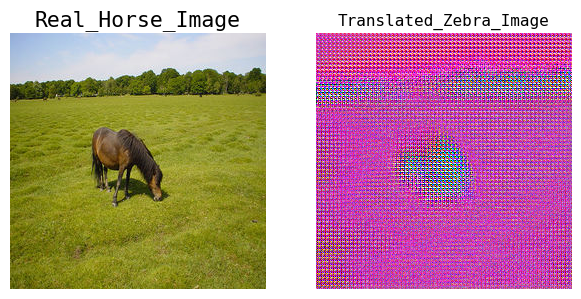

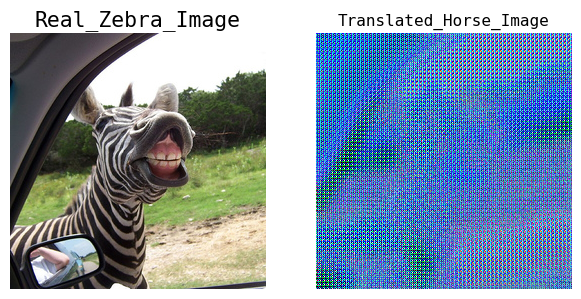

In [19]:
img1 = fe.util.ImgData(Real_Horse_Image=horse_img, Translated_Zebra_Image=fake_zebra)
fig1 = img1.paint_figure()

img2 = fe.util.ImgData(Real_Zebra_Image=zebra_img, Translated_Horse_Image=fake_horse)
fig2 = img2.paint_figure()

Note the addition of zebra-like stripe texture on top of horses when translating from horses to zebras.
When translating zebras to horses, we can observe that generator removes the stripe texture from zebras.